In [58]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
def show_image(fname, path='./image/', size=(20,20)):
    """读取*.png图片并显示"""
    plt.figure(figsize=size)
    plt.imshow(plt.imread(path+fname))
    plt.axis('off')
    plt.show()

In [21]:
def show_describe(data):
    describe = data.describe().T
    for c in data.columns:
        describe.loc[c,'dif_vals'] = len(data[c].unique())
        describe.loc[c,'dtype'] = data[c].dtype
        describe.loc[c,'num_null'] = data[c].isnull().sum()
    for c in ['count','dif_vals','num_null']:
        describe[c] = describe[c].astype(np.int64)
    return describe
        
def show_number_describe(data):
    data_tmp = data.select_dtypes(include = ["number"])
    print('共有：[{0}]条样本，特征数为：[{1}]，其中有[{2}]个特征是number'.format(
            data.shape[0], data.shape[1], data_tmp.shape[1]))
    return show_describe(data_tmp)

def show_object_describe(data):
    data_tmp = data.select_dtypes(include = ["object"])
    print('共有：[{0}]条样本，特征数为：[{1}]，其中有[{2}]个特征是object'.format(
            data.shape[0], data.shape[1], data_tmp.shape[1]))
    return show_describe(data_tmp) 

本文中使用sklearn中的IRIS（鸢尾花）数据集来对特征处理功能进行说明。IRIS数据集由Fisher在1936年整理，包含4个特征（Sepal.Length（花萼长度）、Sepal.Width（花萼宽度）、Petal.Length（花瓣长度）、Petal.Width（花瓣宽度）），特征值都为正浮点数，单位为厘米。目标值为鸢尾花的分类（Iris Setosa（山鸢尾）、Iris Versicolour（杂色鸢尾），Iris Virginica（维吉尼亚鸢尾））。

In [33]:
from sklearn.datasets import load_iris
#导入IRIS数据集
iris = load_iris()
#特征矩阵
print(iris.data[:5])
#目标向量
print(iris.target[:5])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
[0 0 0 0 0]


In [51]:
# 生成iris的DF， 数据类型为number
iris_number = pd.DataFrame(iris.data, columns=iris.feature_names)
# 随机生成缺失值
for i in range(iris_number.shape[1]):
    nan_i = np.random.randint(0,iris_number.shape[0],i*3)
    iris_number.iloc[nan_i,i] = np.nan
# 查看基本信息
show_number_describe(iris_number)

共有：150条样本，特征数为：4，其中有【4】个特征是number


,count,mean,std,min,25%,50%,75%,max,dif_vals,dtype,num_null
sepal length (cm),141,5.840426,0.839811,4.3,5.1,5.8,6.400,7.9,36,float64,9
sepal width (cm),134,3.071642,0.439003,2.0,2.8,3.0,3.375,4.4,24,float64,16
petal length (cm),129,3.802326,1.735361,1.1,1.6,4.3,5.100,6.9,42,float64,21
petal width (cm),124,1.206452,0.756730,0.1,0.3,1.3,1.800,2.5,23,float64,26


In [40]:
# 生成iris的DF， 数据类型为object
iris_object = pd.DataFrame(iris.data, columns=iris.feature_names,dtype=np.str)
# 随机生成缺失值
for i in range(iris_object.shape[1]):
    nan_i = np.random.randint(0,iris_object.shape[0],i**2)
    iris_object.iloc[nan_i,i] = np.nan
# 查看基本信息
show_object_describe(iris_object)

共有：150条样本，特征数为：4，其中有【4】个特征是number


,count,unique,top,freq,dif_vals,dtype,num_null
sepal length (cm),150,36,5.1,9,36,object,0
sepal width (cm),149,24,3.0,24,25,object,1
petal length (cm),146,43,nan,16,44,object,4
petal width (cm),141,23,0.2,21,24,object,9


# 1 数据质量分析

数据质量通常是指数据值的质量，包括**准确性、完整性和一致性**。   
>数据的准确性是指数据不包含错误或异常值，   
>完整性是指数据不包含缺失值，  
>一致性是数据在各个数据源中都是相同的。  

广义的数据质量还包括数据整体的有效性，例如，数据整体是否是可信的、数据的取样是否合理等。

本文的数据质量分析，是指对原始数据值的质量进行分析，以检查数据的质量。没有可信的数据，数据分析将是空中楼阁，因此，数据分析的前提就是要保证数据质量是可信的。

数据质量分析的主要任务是检测原始数据中是否存在脏数据，脏数据一般是指不符合要求，以及不能直接进行相应分析的数据，脏数据一般包括：

* 缺失值
* 异常值（离群点）
* 格式不统一的值

通常情况下，原始数据中都会存在不完整（有缺失值）、不一致、数据异常等问题，这些脏数据会降低数据的质量，影响数据分析的结果，因此，在进行数据分析之前，需要对数据进行清洗、集成、转换等处理，以提高数据的质量。对于内容未知和不一致的数据，通常需要人工识别，进而才能确定处理方法，本文重点介绍缺失值和异常值的分析方法。

## 1.1 缺失值分析
数据的缺失一般是指观测的缺失和观测中变量值的缺失，两者都会造成分析结果的不准确。观测的缺失会导致由样本数据推断出的总体数据的性质和特点出现偏差。   
本小节涉及的是样本中数据值的分析，使用简单的统计分析，可以得到含有缺失值的属性的个数和样本空间的缺失率。缺失的数据可能会对数据分析的结果产生误差，从而使样本数据不能很好地代表数据总体。

### 1.1.1 识别缺失数据
`pandas.isna()`和`numpy.isnan()`两个函数一样，返回逻辑值向量，当变量值为`np.nan`时，把该元素所在的值设置为`True`，表明该元素是`NAN`。

In [41]:
#np.isnan(iris_number)[:5] #效果相同
iris_number.isna()[:5]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,False,True,True,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,True,False,False


### 1.1.2 缺失值分析
含有缺失值的记录和属性，包含缺失值的观测`总数`和`缺失率`。

In [45]:
print(iris_number.isna().sum()) #缺失总数
print(iris_number.isna().sum()/iris_number.shape[0]) #缺失率

sepal length (cm)     9
sepal width (cm)     13
petal length (cm)    16
petal width (cm)     19
dtype: int64
sepal length (cm)    0.060000
sepal width (cm)     0.086667
petal length (cm)    0.106667
petal width (cm)     0.126667
dtype: float64


### 1.1.3 处理缺失值

对缺失值的处理，常用的处理方法是**删除、替换和插补**。

#### 1.1.3.1 删除
* 删除含有（少量）缺失值的（行）
* 删除缺失值太多的特征（行）或 （列） 

In [52]:
# 删除所有含np.nan的行
iris_number.dropna().shape

(91, 4)

In [53]:
# 只针对某一特征删除np.nan
iris_number[~iris_number['sepal length (cm)'].isna()].shape

(141, 4)

#### 1.1.3.2 替换
均值替换法属于插补法的一种简单形式，适用于缺失率低的场景。
常见替换方法：
* 均值mean（常用于number）
* 中位数median （常用于number）
* 众数most_frequent （常用于object）

|插补方法 | 描述 
|-|-|
|均值/中值/众数插补| 用该属性的均值/中值/众数进行插补|
|固定值插补|根据背景知识用某个常量进行插补 |
|最近邻插补|寻找相似的样本，用该样本的属性值插补 |
|回归方法|选择若干个预测缺失值的自变量X，然后建立回归方程 估计缺失值 |
|插值法|利用该变量已有数据建立合适的插值函数进行插补|
最近邻插补：可采用相关系数矩阵来确定哪个变量（X）与缺失值所 在变量（Y）相关。然后把所有样本按X的取值大小 进行排序，变量Y的缺失值可以用排在缺失值前的那个 样本的数据来代替。

In [55]:
# 事先生成中位数，然后直接替换np.nan
median = iris_number['sepal length (cm)'].median()
iris_number['sepal length (cm)'].fillna(median).isnull().sum()

0

In [57]:
# 提前把np.nan替换成别的字符，现在后续处理中再一次替换
iris_number['sepal length (cm)'].fillna('None'
                               ).replace({'None':median}).isnull().sum()

0

#### 1.1.3.3 不处理缺失值

在数据集中保留缺失值，有些模型可以自动处理缺失值，可以不对缺失值做处理

-------------------------

## 1.2 异常值分析
异常值在统计学上的全称是疑似异常值，也称作离群点，异常值的分析也称作离群点分析。异常值是指样本中出现的“极端值”，数据值看起来异常大或异常小，其分布明显偏离其余的观测值。异常值分析是检验数据中是否存在不合常理的数据，在数据分析中，既不能忽视异常值的存在，也不能简单地把异常值从数据分析中剔除。重视异常值的出现，分析其产生的原因，常常成为发现新问题进而改进决策的契机。

### 1.2.1 识别异常值
1. **最值分析**：对变量做一个描述性分析，进而查看哪些数据是不合理的。常用的统计量是最大值和最小值，用来判断变量的取值是否超出了合理的范围，例如，客户年龄的最大值是199，该取值就存在异常。

2. $3\sigma$**原则**：如果数据服从正态分布，在$3\sigma$原则下，异常值被定义为一组测定值中与平均值的偏差超过三倍标准差的值。在正态分布下，距离平均值$3\sigma$之外的值出现的概率为$P(|x-\mu|>3\sigma)\le0.003$，属于极个别的小概率事件。如果数据不服从正态分布，也可以用远离平均值的多少倍标准差来描述。

3. **分位数**：直接计算分位数，0.05~0.995以外的点认为是异常点

4. **通过可视化分析**：通过看直方图上的尾巴，散点图上孤立的点，

5. **箱型图分析**：箱线图提供了识别异常值的一个标准方法：异常值通常被定义为$x<Q_1-1.5IQR$或者$x>Q_3+1.5IQR$ 的值，$Q_1$称为下四分位数， $Q_3$称为上四分位数，$IQR$称为四分位数间距$IQR=Q_3-Q_1$，其间包括了全部观察值的一半。


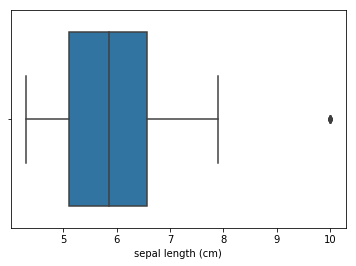

In [63]:
#sns.distplot(iris_number['sepal length (cm)'].fillna(10)) #看直方图上的尾巴
#plt.scatter(np.arange(iris_number.shape[0]),  #看散点图上孤立的点
#            iris_number['sepal length (cm)'].fillna(10))
sns.boxplot(iris_number['sepal length (cm)'].fillna(10)) # 看箱形图中的分位线

### 1.2.2 处理异常值

方法类似缺失值   
注意异常值产生的原因

-----------------------

## 1.3 一致性分析

数据不一致性是指数据的矛盾性，主要是由于数据源不同，导致数据编码的不一致；例如，对于一组数据，性别是M和F，而其他数据源中使用Male和Female表示性别，那么这两种数据就产生编码不一致性的问题。

另外，数据更新不同步也容易导致的数据不一致性，例如，同一个人的工作地点，在不同的数据表中，可能是不同的，这就是在更新数据时，由于更新的不同步导致数据出现不一致性。

再比如全球业务中的时区问题

当数据出现不一致性时，需要对数据进行清洗和集成操作，去除冗余数据、统一变量名、统一数据的计量单位等，并使用最新的数据来消除不一致性。